In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import xgboost as xgb
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [4]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_train = pd.merge(X_train, y_train, on = ['ID'], how = 'left')

In [5]:
X_test = pd.read_csv('X_valid.csv')
X_train = X_train.append(X_test, sort=False).reset_index(drop=True)

In [6]:
X_train['DBM_Request_Time'] = pd.to_datetime(X_train['DBM_Request_Time'])
X_train['Weekday'] = X_train['DBM_Request_Time'].dt.weekday
X_train['Hour'] = X_train['DBM_Request_Time'].dt.hour
X_train['Day'] = X_train['DBM_Request_Time'].dt.day
X_train['Month'] = X_train['DBM_Request_Time'].dt.month
X_train['Month_Day'] = X_train['Month'].astype('str') + '_' + X_train['Day'].astype('str')
X_train['Weekday_Hour'] = X_train['Weekday'].astype(str) + '_' + X_train['Hour'].astype(str)
X_train['Date_Hour'] = X_train['DBM_Request_Time'].apply(lambda x: datetime.datetime(x.year,x.month,x.day,x.hour))
X_train.loc[X_train['Date_Hour'] >= '2019-12-17 18:00:00', 'After_Date'] = 1
X_train.loc[X_train['Date_Hour'] < '2019-12-17 18:00:00', 'After_Date'] = 0
X_train['domen_end'] = X_train['domen'].apply(lambda x: x.split('.')[-1])
X_train['same_lang'] = X_train['Country_Code'].astype('str') + '_' + X_train['DBM_Language'].astype('str')
X_train = X_train.drop(columns = ['DBM_Request_Time'])

In [7]:
a_city = X_train[['City_ID']+['TARGET']].groupby('City_ID').sum().reset_index().sort_values(by=['TARGET'])
b_city = X_train[['City_ID']+['TARGET']].groupby('City_ID').count().reset_index().sort_values(by=['TARGET'])


city_val = list(a_city[a_city['TARGET'] > a_city['TARGET'].sum()*0.001]['City_ID'].values)

a_dbm_mobile = X_train[['DBM_Mobile_Model_ID']+['TARGET']].groupby('DBM_Mobile_Model_ID').sum().reset_index().sort_values(by=['TARGET'])
b_dbm_mobile = X_train[['DBM_Mobile_Model_ID']+['TARGET']].groupby('DBM_Mobile_Model_ID').count().reset_index().sort_values(by=['TARGET'])


dbm_mobile_val = list(a_dbm_mobile[a_dbm_mobile['TARGET'] > a_dbm_mobile['TARGET'].sum()*0.001]['DBM_Mobile_Model_ID'].values)

a_domen = X_train[['domen']+['TARGET']].groupby('domen').sum().reset_index().sort_values(by=['TARGET'])
b_domen = X_train[['domen']+['TARGET']].groupby('domen').count().reset_index().sort_values(by=['TARGET'])


domen_val = list(a_domen[a_domen['TARGET'] > a_domen['TARGET'].sum()*0.001]['domen'].values)

X_train.loc[(~X_train['City_ID'].isin(city_val)),'City_ID'] = '999999'
X_train.loc[(~X_train['DBM_Mobile_Model_ID'].isin(dbm_mobile_val)),'DBM_Mobile_Model_ID'] = 'Other'
X_train.loc[(~X_train['domen'].isin(domen_val)),'domen'] = 'Other'

In [8]:
X_train.loc[(~X_train['City_ID'].isin(city_val)),'City_ID'] = '999999'
X_train.loc[(~X_train['DBM_Mobile_Model_ID'].isin(dbm_mobile_val)),'DBM_Mobile_Model_ID'] = 'Other'
X_train.loc[(~X_train['domen'].isin(domen_val)),'domen'] = 'Other'

In [9]:
cat_cols = list(X_train.drop(columns = ['ID', 'TARGET']).columns)

In [10]:
X_train = reduce_mem_usage(X_train)

Mem. usage decreased to 2161.17 Mb (78.4% reduction)


In [11]:
X_train.to_csv('train_try.csv')

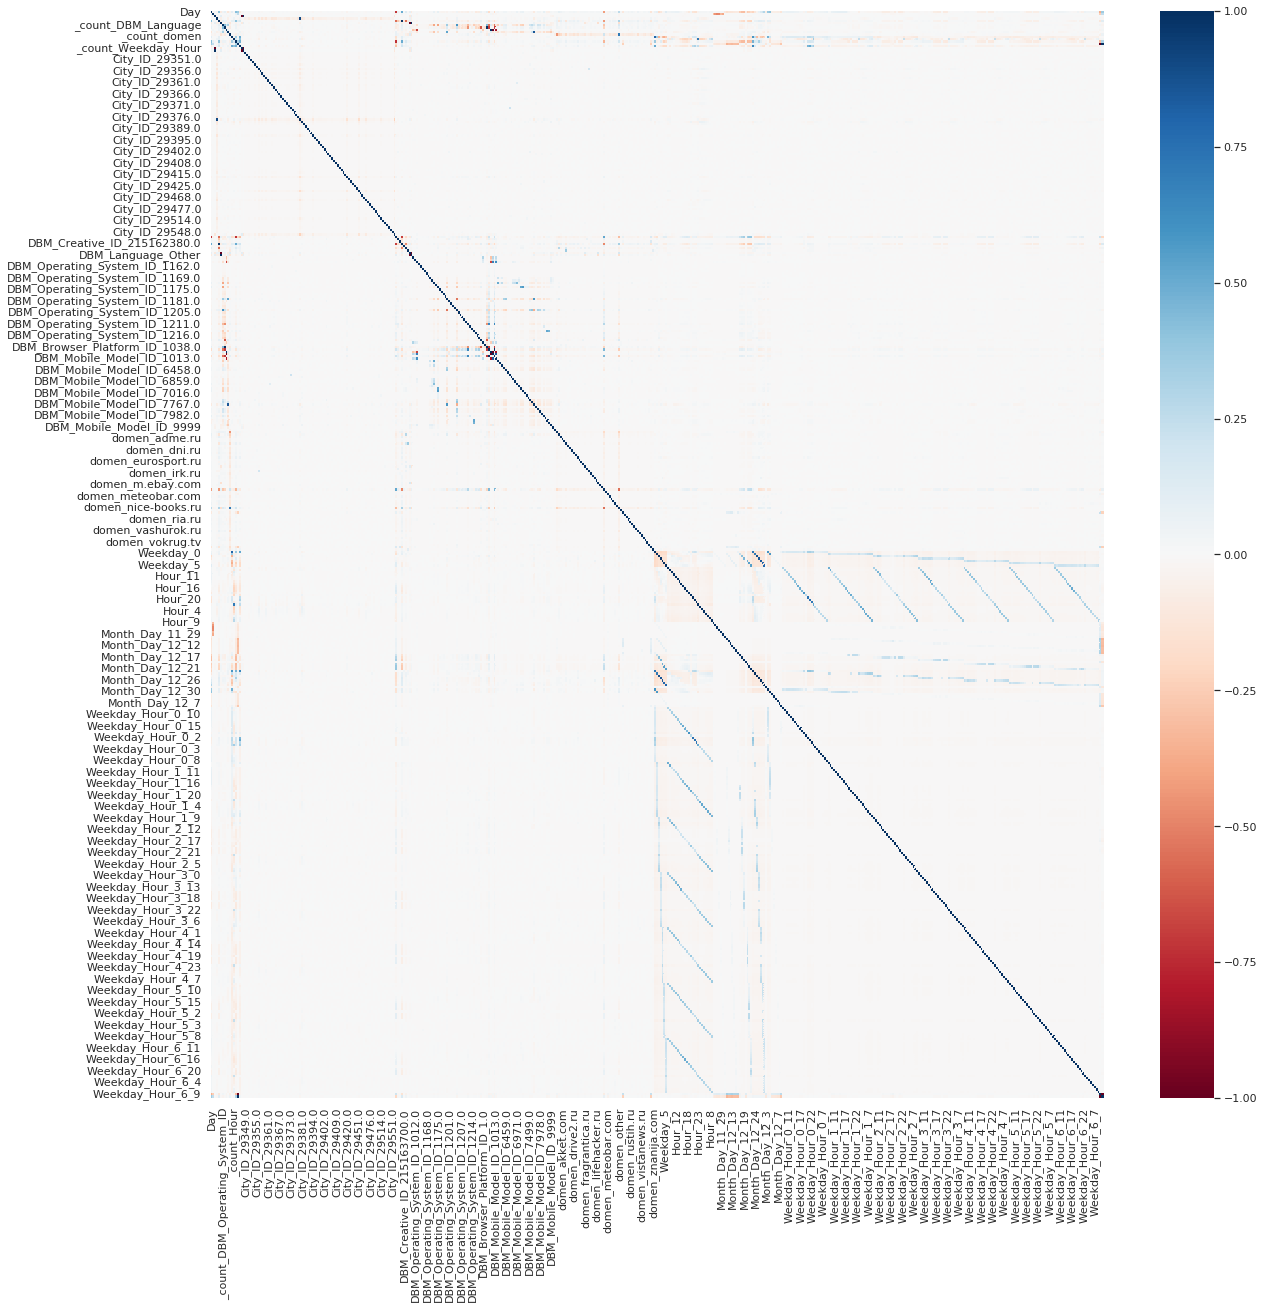

In [14]:
corr_matrix = X_train[-1000000:].corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr_matrix, cmap="RdBu")

In [16]:
corr_matrix.to_excel('corr_matrix.xlsx')

In [12]:
del X_test

In [13]:
# freq encoding
for f in cat_cols:
    vc = X_train[f].value_counts(dropna=False)
    X_train[f'_count_{f}'] = X_train[f].map(vc)

In [ ]:
for i in cat_cols:
    if i in X_train.columns:
        X_train[i] = X_train[i].astype(str)

enc_cols = []
for i, t in X_train.loc[:, X_train.columns != 'TARGET'].dtypes.iteritems():
    if t == object:
        enc_cols.append(i)
        X_train = pd.concat([X_train, pd.get_dummies(X_train[i].astype(str), prefix=i)], axis=1)
        X_train.drop(i, axis=1, inplace=True)
#         X_train[i] = pd.factorize(X_train[i])[0]
#         X_train[i] = X_train[i].astype('category')
print(enc_cols)

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
splits = kfold.split(X_train, y_train)

In [ ]:
df1 = X_train.copy()
df1.reset_index(inplace=True)

new_features = []

check = False
for train_idx, valid_idx in splits:
    
    # Train/validation split
    X_train, X_valid = df1.iloc[train_idx,:], df1.iloc[valid_idx,:]
    
    # Mean encoding
    for col in cat_cols:
        means = X_valid[col].map(X_train.groupby(col).TARGET.mean())
        summm = X_valid[col].map(X_train.groupby(col).TARGET.sum())
        
        col_mean = col+'_target_mean'
        col_sum = col+'_target_sum'
        
        X_valid[col_mean] = means
        X_valid[col_sum] = summm
        
        # Results
        df1.loc[valid_idx, col_mean] = X_valid[col_mean]
        df1.loc[valid_idx, col_sum] = X_valid[col_sum]
        
        # Store new columns
        if check==False:
            new_features.append(col_mean)
            new_features.append(col_sum)
            
    check = True

print(new_features)

In [ ]:
# Dealing with missing values
new_features = ['shop_id_target_enc', 'item_id_target_enc', 'city_code_target_enc',
                'item_category_id_x_target_enc', 'type_code_target_enc', 'subtype_code_target_enc']
prior = np.mean(df1['item_cnt_month'].values)
df1[new_features] = df1[new_features].fillna(prior)
df1.head()

In [ ]:
for i in cat_cols:
    if i in X_train.columns:
        X_train[i] = X_train[i].astype(str)

enc_cols = []
for i, t in X_train.loc[:, X_train.columns != 'TARGET'].dtypes.iteritems():
    if t == object:
        enc_cols.append(i)
        X_train = pd.concat([X_train, pd.get_dummies(X_train[i].astype(str), prefix=i)], axis=1)
        X_train.drop(i, axis=1, inplace=True)
print(enc_cols)

val_feach = list(X_train.drop(columns=['DBM_Request_Time']).columns)
X_train_val = X_train[val_feach].copy()

In [3]:
X_train_val_1=pd.read_pickle('X_train_val_v1_part1.pickle')
X_train_val_2=pd.read_pickle('X_train_val_v1_part2.pickle')
X_train_val_3=pd.read_pickle('X_train_val_v1_part3.pickle')

In [4]:
X_train_val = pd.concat([X_train_val_1,X_train_val_2,X_train_val_3], ignore_index=True)
X_train_val = X_train_val.drop(columns = ['Date_Hour'])

In [5]:
X_train = X_train_val[~X_train_val['TARGET'].isna()].copy().reset_index(drop = True)
X_test = X_train_val[X_train_val['TARGET'].isna()].copy().reset_index(drop = True)

In [6]:
y_train = X_train['TARGET']
y_test = X_test['TARGET']

X_train = X_train.drop(columns = ['TARGET'])
X_test = X_test.drop(columns = ['TARGET'])

In [7]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

In [8]:
X=X_train.copy()
y=y_train.copy()

In [9]:
del X_train_val_1
del X_train_val_2
del X_train_val_3
del X_train_val
del X_train
del y_train

In [10]:
feature_importances = pd.read_csv('feature_importances.csv')
cols = list(feature_importances.sort_values(by = ['average'], ascending = False).reset_index(drop = True)['feature'][:300].values)


In [11]:
X = X[cols].copy()

In [1]:
%%time
from sklearn.metrics import roc_auc_score

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
i=0
for fold_n, (train_index, valid_index) in enumerate(splits):
    i=i+1
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 700, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=700)
    
    with open('model'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(clf, f)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid

    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

In [ ]:
X_valid = pd.read_csv('X_valid.csv')
X_valid['TARGET'] = y_preds
X_valid[['ID','TARGET']].to_csv('sub_6.csv', index=False)

In [ ]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(200), x='average', y='feature');
plt.title('200 TOP feature importance over {} folds average'.format(folds.n_splits));